<a href="https://colab.research.google.com/github/DifferentiableUniverseInitiative/DHOD/blob/master/nb/Zheng2007_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Implementation of Zheng2007 in DiffHOD 

Authors:
  - [@EiffL](https://github.com/EiffL) (Francois Lanusse)
  - [@bhorowitz](https://github.com/bhorowitz) (Ben Horowitz)

## Overview

This notebook illustrates how to implenent Zheng2007, and compare the results to halotools.

## Preliminary setup

Here we download and install all the requirements, as well as a test halo catalog provided with halotools.

In [ ]:
# Installing dependencies
!pip install --quiet -i https://test.pypi.org/simple/ halotools
!pip install --quiet git+https://github.com/DifferentiableUniverseInitiative/DHOD.git
# Downloading halo catalog for use with halotools
!download_initial_halocat.py 

In [6]:
# Importing all utilities needed
%pylab inline
import tensorflow as tf
print("TensorFlow Version", tf.__version__)
import tensorflow_probability as tfp
print("TensorFlow Probability Version", tfp.__version__)
tfd = tfp.distributions
tfb = tfp.bijectors
import edward2 as ed

# DiffHOD imports
from diffhod.components import Zheng07Cens, Zheng07SatsRelaxedBernoulli, NFWProfile
from diffhod.utils import cic_paint

# halotools imports
from halotools.sim_manager import CachedHaloCatalog
from halotools.empirical_models import PrebuiltHodModelFactory
from halotools.mock_observables.two_point_clustering import tpcf
from halotools.mock_observables import return_xyz_formatted_array

Populating the interactive namespace from numpy and matplotlib
TensorFlow Version 2.5.0
TensorFlow Probability Version 0.13.0


## Prepare halo catalog

In [7]:
# Load a reference halo catalog
halocat = CachedHaloCatalog(simname = 'bolshoi', redshift=-0.003) 

# Removing subhalos and convert table to tensors
halo_table = halocat.halo_table
halo_table = halo_table[halo_table['halo_pid'] == -1]
tf_halocat = {k: tf.convert_to_tensor(halo_table[k], dtype=tf.float32) for k in halo_table.colnames}

## Model definition

We now define our HOD, first using halotools:

In [9]:
# We first load our reference halotools model
zheng07_model = PrebuiltHodModelFactory('zheng07', 
                                        redshift =-0.003, 
                                        modulate_with_cenocc=True)

And now, the equivalent using DiffHOD to compose the HOD:

In [10]:
# Here is how we define the same model in diffhod
@tf.function
def hod(halo_cat, max_sat=60, temp=0.00001, params = zheng07_model.param_dict):

  ### Occupation model ###
  n_cen = Zheng07Cens(halo_cat['halo_mvir'],
                      **params,
                      temperature=temp)
  
  n_sat = Zheng07SatsRelaxedBernoulli(halo_cat['halo_mvir'],
                                      n_cen,
                                      **params,
                                      sample_shape=(max_sat,),
                                      temperature=temp)
  
  ### Phase Space model ###
  # Centrals are just located at center of halo
  pos_cen = ed.Deterministic(tf.stack([halo_cat['halo_x'],
                                        halo_cat['halo_y'],
                                        halo_cat['halo_z']], axis=-1))
    
  # Satellites follow an NFW profile centered on halos
  pos_sat = NFWProfile(pos=pos_cen,
                        concentration=halo_cat['halo_nfw_conc'],
                        Rvir=halo_cat['halo_rvir'],
                        sample_shape=(max_sat,))
  
  return {'pos_cen':pos_cen, 'pos_sat':pos_sat, 'n_cen':n_cen, 'n_sat':n_sat}

#### Sampling galaxies with both models

In [12]:
# sampling galaxies from the model
gal_cat = hod(tf_halocat)

In [13]:
# Same thing with halotools
zheng07_model.populate_mock(halocat) 

## Testing 2pt function

In [14]:
# Let's define halotools samples
ht_sample = return_xyz_formatted_array(zheng07_model.mock.galaxy_table['x'],
                                       zheng07_model.mock.galaxy_table['y'],
                                       zheng07_model.mock.galaxy_table['z'])
m = zheng07_model.mock.galaxy_table['host_centric_distance'] <0.0001
ht_cens = ht_sample[m]
ht_sats = ht_sample[~m]

In [15]:
# Same thing for dhod
p = gal_cat['n_cen']>0.5
tf_cens = gal_cat['pos_cen'][p[0]].numpy()
p = gal_cat['n_sat']>0.5
tf_sats = gal_cat['pos_sat'][p[:,0,:]].numpy().reshape((-1,3))
tf_sample = np.concatenate([tf_cens, tf_sats], axis=0)

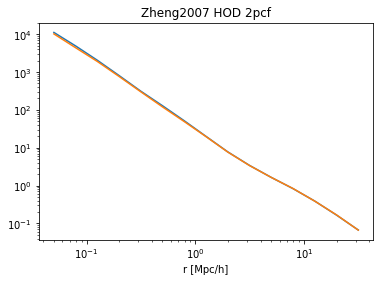

In [16]:
rbins = np.logspace(-1.5, 1.5, 16)
xi_ht = tpcf(ht_sample, rbins, period=halocat.Lbox)
xi_tf = tpcf(tf_sample, rbins, period=halocat.Lbox)

loglog(rbins[1:],xi_ht, label='halotools')
loglog(rbins[1:],xi_tf, label='DHOD')
xlabel('r [Mpc/h]')
title('Zheng2007 HOD 2pcf');

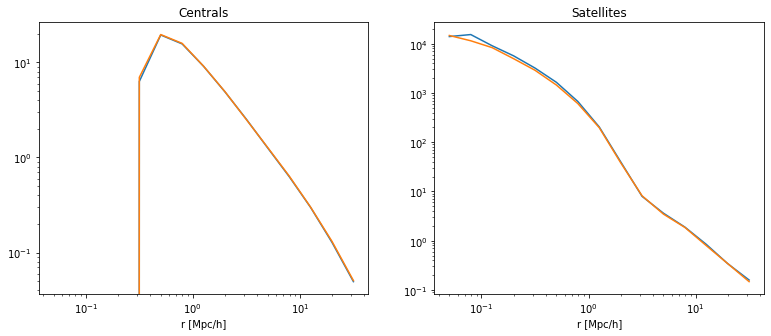

In [17]:
xi_ht_cen = tpcf(ht_cens, rbins, period=halocat.Lbox)
xi_tf_cen = tpcf(tf_cens, rbins, period=halocat.Lbox)
xi_ht_sat = tpcf(ht_sats, rbins, period=halocat.Lbox)
xi_tf_sat = tpcf(tf_sats, rbins, period=halocat.Lbox)

figure(figsize=(13,5))
subplot(121)
loglog(rbins[1:],xi_ht_cen, label='halotools')
loglog(rbins[1:],xi_tf_cen, label='DHOD')
xlabel('r [Mpc/h]')
title('Centrals');

subplot(122)
loglog(rbins[1:],xi_ht_sat, label='halotools')
loglog(rbins[1:],xi_tf_sat, label='DHOD')
xlabel('r [Mpc/h]')
title('Satellites');

## Occupancy Distributions


In [18]:
import scipy
import copy 

hod_params = copy.deepcopy(zheng07_model.param_dict)

In [19]:
out_sat = []
out_cen = []

binned_out_sat = scipy.stats.binned_statistic(np.log10(zheng07_model.mock.halo_table["halo_mvir"]),zheng07_model.mock.halo_table["halo_num_satellites"],bins=50)
binned_out_cen = scipy.stats.binned_statistic(np.log10(zheng07_model.mock.halo_table["halo_mvir"]),zheng07_model.mock.halo_table["halo_num_centrals"],bins=50)

for tau in [1,0.75,0.02,0.001]:
# sampling galaxies from the model
    gal_cat = hod(tf_halocat,temp = tau,params=hod_params)
    binned_out_sat_tf = scipy.stats.binned_statistic(np.log10(tf_halocat["halo_mvir"]),tf.reduce_sum(gal_cat['n_sat'],axis=0),bins=50)
    binned_out_cen_tf = scipy.stats.binned_statistic(np.log10(tf_halocat["halo_mvir"]),gal_cat['n_cen'],bins=50)

    out_sat.append(binned_out_sat_tf)
    out_cen.append(binned_out_cen_tf)

In [20]:
#pretty plot

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['text.usetex'] = False
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

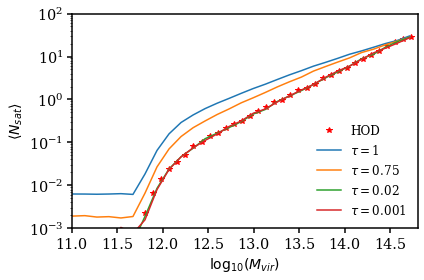

In [21]:
plt.plot((binned_out_sat.bin_edges[1:] + binned_out_sat.bin_edges[:-1])/2,binned_out_sat.statistic,"r*",label="HOD")

tt = [1,0.75,0.02,0.001]

for n,os in enumerate(out_sat):
    plt.plot((os.bin_edges[1:] + os.bin_edges[:-1])/2,os.statistic[0],label=r"$\tau = $" + str(tt[n]))
plt.legend(loc=4,fontsize=12)
plt.semilogy()
plt.ylabel(r"$\langle N_{sat} \rangle$",fontsize=14)
plt.xlabel(r"$\log_{10}(M_{vir})$",fontsize=14)
plt.ylim(0.001,100)
plt.xlim(11.0,14.80)
plt.tight_layout()
plt.savefig("occupancy_sat.pdf")

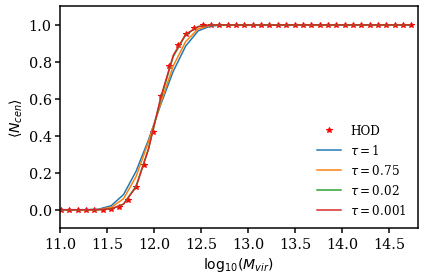

In [22]:
plt.plot((binned_out_cen.bin_edges[1:] + binned_out_cen.bin_edges[:-1])/2,binned_out_cen.statistic,"r*",label="HOD")

tt = [1,0.75,0.02,0.001]

for n,os in enumerate(out_cen):
    plt.plot((os.bin_edges[1:] + os.bin_edges[:-1])/2,os.statistic[0],label=r"$\tau = $" + str(tt[n]))
plt.legend(loc=4,fontsize=12)
#plt.semilogy()
plt.ylabel(r"$\langle N_{cen} \rangle$",fontsize=14)
plt.xlabel(r"$\log_{10}(M_{vir})$",fontsize=14)
plt.ylim(-0.1,1.1)
plt.xlim(11.0,14.80)
plt.tight_layout()

plt.savefig("occupancy_cen.pdf")


In [24]:
# choosing subvolume so we can play around easier with derivatives

# Load a reference halo catalog
halocat = CachedHaloCatalog(simname = 'bolshoi', redshift=-0.003) 

# Removing subhalos and convert table to tensors
halo_table = halocat.halo_table
halo_table = halo_table[halo_table['halo_pid'] == -1]


halo_table = halo_table[halo_table['halo_x'] < 128]
halo_table = halo_table[halo_table['halo_y'] < 128]
halo_table = halo_table[halo_table['halo_z'] < 128]
tf_halocat = {k: tf.convert_to_tensor(halo_table[k], dtype=tf.float32) for k in halo_table.colnames}

In [35]:
#for some reason I can't get derivatives of all bandpowers at once with this sort of setup and end up looping through them isntead...
#easier than debugging the grad function :D

tau_array = [0.001,0.02,1.0]
sat_array =[]

cen_array =[]
for tau in tau_array:
    print(tau)
    bins = tf.linspace(tf.math.reduce_min(np.log10(tf_halocat["halo_mvir"])), tf.math.reduce_max(np.log10(tf_halocat["halo_mvir"])), 50)

    def ncen(x):
        logMmin,sigma_logM,logM0,logM1,alpha = tf.transpose(x)
        params = {'logMmin':logMmin, 'sigma_logM':sigma_logM,
                  'logM0':logM0,'logM1':logM1, 'alpha':alpha}
        tf_gal = hod(tf_halocat,max_sat=30,temp=tau, params=params)
        a=tfp.stats.histogram(tf.math.log(tf_halocat["halo_mvir"])/tf.math.log(10.0),bins,weights=tf_gal['n_cen'])
        b=tfp.stats.histogram(tf.math.log(tf_halocat["halo_mvir"])/tf.math.log(10.0),bins)
        return a/b


    def nsat(x):
        logMmin,sigma_logM,logM0,logM1,alpha = tf.transpose(x)
        params = {'logMmin':logMmin, 'sigma_logM':sigma_logM,
                  'logM0':logM0,'logM1':logM1, 'alpha':alpha}
        tf_gal = hod(tf_halocat,max_sat=30,temp=tau, params=params)
        a=tfp.stats.histogram(tf.math.log(tf_halocat["halo_mvir"])/tf.math.log(10.0),bins,weights=tf.reduce_sum(tf_gal['n_sat'],axis=0))
        b=tfp.stats.histogram(tf.math.log(tf_halocat["halo_mvir"])/tf.math.log(10.0),bins)
        return a/b
    
    #checking gradients...
    out_ar = []
    x = tf.Variable([12.02,  0.26, 11.38, 13.31,  0000001.9900010])
    print(ncen(x))#[[12.02,12.02,], [0.26,0.26,], [11.38,11.38,], [13.31,13.31,], [x,x,]]))
    #loss_ar.append(np.array(L))
    for nn in range(0,49):
        def get_grads(x):
            with tf.GradientTape(persistent=True) as g:
             #  g.watch(x)
               L = nsat(x)[nn]
            dL_dx = g.gradient(L, x)
            return dL_dx
        #a = tf.constant((np.array([[12.5,0.5,11.38,13.01, x]],dtype=np.float32)))
        grad = get_grads(x)
        out_ar.append(np.array(grad))
        print(nn,grad)
    sat_array.append(np.array(out_ar))
    out_ar = []
    #same for centrals
    x = tf.Variable([12.02,  0.26, 11.38, 13.31,  0000001.9900010])
    print(ncen(x))#[[12.02,12.02,], [0.26,0.26,], [11.38,11.38,], [13.31,13.31,], [x,x,]]))
    #loss_ar.append(np.array(L))
    for nn in range(0,49):
        def get_grads(x):
            with tf.GradientTape(persistent=True) as g:
             #  g.watch(x)
               L = ncen(x)[nn]
            dL_dx = g.gradient(L, x)
            return dL_dx
        #a = tf.constant((np.array([[12.5,0.5,11.38,13.01, x]],dtype=np.float32)))
        grad = get_grads(x)
        out_ar.append(np.array(grad))
        print(nn,grad)
    cen_array.append(np.array(out_ar))


0.001
tf.Tensor(
[0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 3.9763014e-05 4.3504740e-05 1.0940319e-04 1.4310246e-04
 8.9229943e-05 2.2606533e-04 1.4526438e-04 2.4366993e-03 2.0185102e-02
 7.0087798e-02 2.1114607e-01 4.6965095e-01 7.0611876e-01 8.7755436e-01
 9.6222222e-01 9.9016851e-01 1.0000000e+00 1.0000000e+00 1.0000000e+00
 1.0000000e+00 1.0000000e+00 1.0000000e+00 1.0000000e+00 1.0000000e+00
 1.0000000e+00 1.0000000e+00 1.0000000e+00 1.0000000e+00 1.0000000e+00
 1.0000000e+00 1.0000000e+00 1.0000000e+00 1.0000000e+00], shape=(49,), dtype=float32)
0 tf.Tensor([nan nan nan nan nan], shape=(5,), dtype=float32)
1 tf.Tensor([nan nan nan nan nan], shape=(5,), dtype=float32)
2 tf.Tensor([nan nan nan nan nan], shape=(5,), dtype=float32)
3 tf.Tensor([nan nan nan nan nan], shape=(5,), dtype=float32)
4 tf.Tens

In [36]:
#analytical derivatives

def dncendlogmin(M):
    logMmin, sigma_logM, logM0, logM1, alpha = [12.02,  0.26, 11.38, 13.31,  0000001.9900010]
    exp = np.exp(-(M-logMmin)**2/sigma_logM**2.0)
    print((sigma_logM*np.sqrt(np.pi)*logMmin))
    return -exp*10/(sigma_logM*np.sqrt(np.pi)*M)
    
def dncendsigma(M):
    logMmin, sigma_logM, logM0, logM1, alpha = [12.02,  0.26, 11.38, 13.31,  0000001.9900010]
    exp = np.exp(-(M-logMmin)**2/sigma_logM**2.0)
    print((sigma_logM*np.sqrt(np.pi)*logMmin))
    return -exp*1/(sigma_logM**2.0*np.sqrt(np.pi)) * (M-logMmin)

def dnsatdlogmin(M):
    logMmin, sigma_logM, logM0, logM1, alpha = [12.02,  0.26, 11.38, 13.31,  0000001.9900010]
    exp = np.exp(-(M-logMmin)**2/sigma_logM**2.0)
    print((sigma_logM*np.sqrt(np.pi)*logMmin))
    pref = ((10**M-10**logM0)/(10**logM1))**alpha
    return -exp*10/(sigma_logM*np.sqrt(np.pi)*M)*pref
    
def dnsatdsigma(M):
    logMmin, sigma_logM, logM0, logM1, alpha = [12.02,  0.26, 11.38, 13.31,  0000001.9900010]
    exp = np.exp(-(M-logMmin)**2/sigma_logM**2.0)
    print((sigma_logM*np.sqrt(np.pi)*logMmin))
    pref = ((10**M-10**logM0)/(10**logM1))**alpha

    return -exp*1/(sigma_logM**2.0*np.sqrt(np.pi)) * (M-logMmin)*pref


def dnsatdalpha(M):
    logMmin, sigma_logM, logM0, logM1, alpha = [12.02,  0.26, 11.38, 13.31,  0000001.9900010]
    pref = 1/2*(1+ scipy.special.erf((M-logMmin)/sigma_logM))

    return pref *((10**M-10**logM0)/(10**logM1))**(alpha) * np.log((10**M-10**logM0)/(10**logM1))

def dnsatdlogM0(M):
    logMmin, sigma_logM, logM0, logM1, alpha = [12.02,  0.26, 11.38, 13.31,  0000001.9900010]
    pref = 1/2*(1+ scipy.special.erf((M-logMmin)/sigma_logM))

    return 1/2*pref *((10**M-10**logM0)/(10**logM1))**(alpha-1) * -1*alpha/logM1


def dnsatdlogM1(M):
    logMmin, sigma_logM, logM0, logM1, alpha = [12.02,  0.26, 11.38, 13.31,  0000001.9900010]
    pref = 1/2*20*(1+ scipy.special.erf((M-logMmin)/sigma_logM))

    return pref *((10**M-10**logM0)/(10**logM1))**(alpha) * -1*alpha/logM1

5.539272774849919
5.539272774849919
5.539272774849919
5.539272774849919


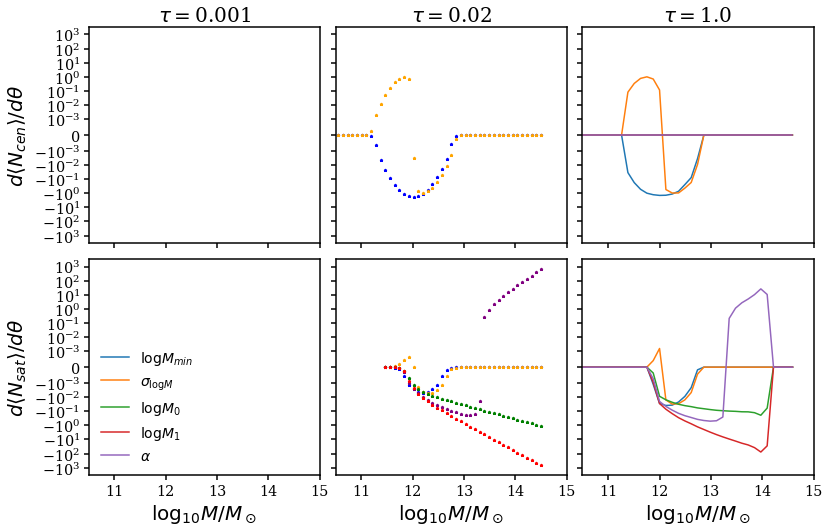

In [37]:

fig, ax = plt.subplots(2, 3,sharex=True,sharey=True)
fig.set_size_inches(11.5, 7.5)

ll = [r'$\logM_{min}$', r'$\sigma_{\log M}$', r'$\log M_0$', r'$\log M_1$', r'$\alpha$']

ax[0,0].set_ylabel(r"$d\langle N_{cen} \rangle/d\theta$",fontsize=20)
ax[1,0].set_ylabel(r"$d\langle N_{sat} \rangle/d\theta$",fontsize=20)

for i,xx in enumerate(cen_array):
    for j in range(0,5):
        ax[0,i].plot((bins[1:]+bins[:-1])/2,xx[:,j],label = ll[j])  
    ax[0,i].set_xlim(10.5,15)
  #  ax[0,i].set_ylabel(r"$d\langle N_{sat} \rangle/d\theta$")
    ax[0,i].set_yscale('symlog', linthreshy=0.0010)
    ax[0,i].set_title(r'$\tau = $' + str(tau_array[i]),fontsize=20)

for i,xx in enumerate(sat_array):
    for j in range(0,5):
        ax[1,i].plot((bins[1:]+bins[:-1])/2,xx[:,j],label = ll[j])
    ax[1,i].set_xlim(10.5,15)
    ax[1,i].set_yscale('symlog', linthreshy=0.0010)
    ax[1,i].set_xlabel(r'$\log_{10} M/M_\odot$',fontsize=20)
    #ax[0,i].set_title(r'$\tau = $' + str(tau_array[i]))

    
ax[0,1].plot(np.linspace(10,14.5,50),dncendlogmin(np.linspace(10,14.5,50)),"b*",markersize=3)
ax[0,1].plot(np.linspace(10,14.5,50),dncendsigma(np.linspace(10,14.5,50)),"*",color="orange",markersize=3)



ax[1,1].plot(np.linspace(10,14.5,50),dnsatdlogmin(np.linspace(10,14.5,50)),"b*",markersize=3)
ax[1,1].plot(np.linspace(10,14.5,50),dnsatdsigma(np.linspace(10,14.5,50)),"*",color="orange",markersize=3)
ax[1,1].plot(np.linspace(10,14.5,50),dnsatdalpha(np.linspace(10,14.5,50)),"*",color="purple",markersize=3)
ax[1,1].plot(np.linspace(10,14.5,50),dnsatdlogM0(np.linspace(10,14.5,50)),"*",color="green",markersize=3)

ax[1,1].plot(np.linspace(10,14.5,50),dnsatdlogM1(np.linspace(10,14.5,50)),"*",color="red",markersize=3)

plt.subplots_adjust(wspace=0, hspace=0)

ax[1,0].legend(loc=3,fontsize=14)

plt.tight_layout()
plt.savefig("3panel.pdf")

## Derivatives of Power Spectra